In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
mod2_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
mod2_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
mod2_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
mod2_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
mod2_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
mod2_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

mod2_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
mod2_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
mod2_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

mod2_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
mod2_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
mod2_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [9]:
mod2_s1d1 = mod2_s1d1.X.toarray()
mod2_s1d2 = mod2_s1d2.X.toarray()
mod2_s1d3 = mod2_s1d3.X.toarray()
mod2_s2d1 = mod2_s2d1.X.toarray()
mod2_s2d4 = mod2_s2d4.X.toarray()
mod2_s2d5 = mod2_s2d5.X.toarray()

mod2_s3d1 = mod2_s3d1.X.toarray()
mod2_s3d6 = mod2_s3d6.X.toarray()
mod2_s3d7 = mod2_s3d7.X.toarray()

mod2_s4d1 = mod2_s4d1.X.toarray()
mod2_s4d8 = mod2_s4d8.X.toarray()
mod2_s4d9 = mod2_s4d9.X.toarray()

In [10]:
print(mod2_s1d1.shape)
print(mod2_s4d1.shape)

(5616, 13431)
(415, 13431)


In [11]:
mod1_train = pd.read_csv('train_atac_binary_8000var_features.csv')
mod1_test = pd.read_csv('test_atac_binary_8000var_features.csv')

In [12]:
mod1_train = mod1_train.transpose()
mod1_test = mod1_test.transpose()

In [13]:
mod1_train['batch'] = mod1_train.index.str[-4:]
mod1_test['batch'] = mod1_test.index.str[-4:]

In [14]:
mod1_train = mod1_train.iloc[1:, :]
mod1_train.reset_index(drop=True, inplace=True)

mod1_test = mod1_test.iloc[1:, :]
mod1_test.reset_index(drop=True, inplace=True)

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']

['s4d1', 's4d8', 's4d9']

In [15]:
mod1_s1d1 = mod1_train[mod1_train['batch'] == 's1d1']
mod1_s1d2 = mod1_train[mod1_train['batch'] == 's1d2']
mod1_s1d3 = mod1_train[mod1_train['batch'] == 's1d3']
mod1_s2d1 = mod1_train[mod1_train['batch'] == 's2d1']
mod1_s2d4 = mod1_train[mod1_train['batch'] == 's2d4']
mod1_s2d5 = mod1_train[mod1_train['batch'] == 's2d5']
mod1_s3d1 = mod1_train[mod1_train['batch'] == 's3d1']
mod1_s3d6 = mod1_train[mod1_train['batch'] == 's3d6']
mod1_s3d7 = mod1_train[mod1_train['batch'] == 's3d7']

In [16]:
mod1_s4d1 = mod1_test[mod1_test['batch'] == 's4d1']
mod1_s4d8 = mod1_test[mod1_test['batch'] == 's4d8']
mod1_s4d9 = mod1_test[mod1_test['batch'] == 's4d9']

In [17]:
batch_s1d1 = mod1_s1d1["batch"]
batch_s1d2 = mod1_s1d2["batch"]
batch_s1d3 = mod1_s1d3["batch"]
batch_s2d1 = mod1_s2d1["batch"]
batch_s2d4 = mod1_s2d4["batch"]
batch_s2d5 = mod1_s2d5["batch"]

batch_s3d1 = mod1_s3d1["batch"]
batch_s3d6 = mod1_s3d6["batch"]
batch_s3d7 = mod1_s3d7["batch"]

batch_s4d1 = mod1_s4d1["batch"]
batch_s4d8 = mod1_s4d8["batch"]
batch_s4d9 = mod1_s4d9["batch"]

In [18]:
mod1_s1d1 = mod1_s1d1.drop('batch', axis=1)
mod1_s1d2 = mod1_s1d2.drop('batch', axis=1)
mod1_s1d3 = mod1_s1d3.drop('batch', axis=1)
mod1_s2d1 = mod1_s2d1.drop('batch', axis=1)
mod1_s2d4 = mod1_s2d4.drop('batch', axis=1)
mod1_s2d5 = mod1_s2d5.drop('batch', axis=1)

mod1_s3d1 = mod1_s3d1.drop('batch', axis=1)
mod1_s3d6 = mod1_s3d6.drop('batch', axis=1)
mod1_s3d7 = mod1_s3d7.drop('batch', axis=1)

mod1_s4d1 = mod1_s4d1.drop('batch', axis=1)
mod1_s4d8 = mod1_s4d8.drop('batch', axis=1)
mod1_s4d9 = mod1_s4d9.drop('batch', axis=1)

In [19]:
mod1_s1d1 = mod1_s1d1.to_numpy()
mod1_s1d2 = mod1_s1d2.to_numpy()
mod1_s1d3 = mod1_s1d3.to_numpy()
mod1_s2d1 = mod1_s2d1.to_numpy()
mod1_s2d4 = mod1_s2d4.to_numpy()
mod1_s2d5 = mod1_s2d5.to_numpy()

mod1_s3d1 = mod1_s3d1.to_numpy()
mod1_s3d6 = mod1_s3d6.to_numpy()
mod1_s3d7 = mod1_s3d7.to_numpy()

mod1_s4d1 = mod1_s4d1.to_numpy()
mod1_s4d8 = mod1_s4d8.to_numpy()
mod1_s4d9 = mod1_s4d9.to_numpy()

In [20]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [21]:
train_input = [mod1_s1d1, mod1_s1d2, mod1_s1d3, mod1_s2d1, mod1_s2d4, mod1_s2d5]
train_output = [mod2_s1d1, mod2_s1d2, mod2_s1d3, mod2_s2d1, mod2_s2d4, mod2_s2d5]

val_input = [mod1_s3d1, mod1_s3d6, mod1_s3d7]
val_output = [mod2_s3d1, mod2_s3d6, mod2_s3d7]

test_input = [mod1_s4d1, mod1_s4d8, mod1_s4d9]
test_output = [mod2_s4d1, mod2_s4d8, mod2_s4d9]

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(37087, 8000)
(7865, 8000)
(1000, 8000)


In [25]:
print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

(37087, 13431)
(7865, 13431)
(1000, 13431)


Load protein to RNA data

In [26]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_mod2.h5ad'

In [27]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [28]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [29]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [30]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [31]:
pro_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [64]:
print(mod1_s1d1.shape, mod1_s1d2.shape, mod1_s1d3.shape, mod1_s2d1.shape, mod1_s2d4.shape, mod1_s2d5.shape, mod1_s3d1.shape, mod1_s3d6.shape, mod1_s3d7.shape)
print(pro_s1d1.shape, pro_s1d2.shape, pro_s1d3.shape, pro_s2d1.shape, pro_s2d4.shape, pro_s2d5.shape, pro_s3d1.shape, pro_s3d6.shape, pro_s3d7.shape)

(5616, 8000) (6069, 8000) (3875, 8000) (3811, 8000) (5456, 8000) (4395, 8000) (0, 8000) (1771, 8000) (6094, 8000)
(4721, 134) (4464, 134) (5484, 134) (9353, 134) (5026, 134) (8206, 134) (8582, 134) (9977, 134) (10362, 134)


In [61]:
RNA_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [33]:
pro_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [34]:
RNA_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [35]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [36]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [37]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [38]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [39]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [40]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [41]:
train_input_ = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]
train_output_ = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]

val_input_ = [pro_s3d1, pro_s3d6, pro_s3d7]
val_output_ = [RNA_s3d1, RNA_s3d6, RNA_s3d7]

test_input_ = [pro_s4d1, pro_s4d8, pro_s4d9]
test_output_ = [RNA_s4d1, RNA_s4d8, RNA_s4d9]

In [42]:
train_input_ = train_input_ + val_input_
train_output_ = train_output_ + val_output_

In [43]:
train_input_ = np.concatenate(train_input_, axis=0)
val_input_ = np.concatenate(val_input_, axis=0)
test_input_ = np.concatenate(test_input_, axis=0)

train_output_ = np.concatenate(train_output_, axis=0)
val_output_ = np.concatenate(val_output_, axis=0)
test_output_ = np.concatenate(test_output_, axis=0)

In [44]:
train_input = np.float64(train_input)
train_output = np.float64(train_output)
val_input = np.float64(val_input)
val_output = np.float64(val_output)
test_input = np.float64(test_input)
test_output = np.float64(test_output)

In [45]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [46]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [47]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [48]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [49]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [50]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [51]:
batch_train = batch_train + batch_val

In [52]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([37087, 1])

In [53]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([7865, 1])

In [54]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [55]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [56]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [57]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [58]:
PATH = 'No_norm_model_DNA_RNA_binary'

In [59]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.1715832  Validation_loss:  0.17957889  Test_loss:  0.13174516


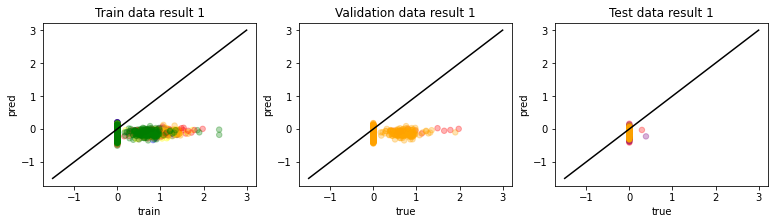

Epoch  100 Train_loss:  0.1202065  Validation_loss:  0.12788883  Test_loss:  0.072253555


KeyboardInterrupt: 

In [60]:
num_epochs = 20001
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

In [ ]:
num_epochs = 50001
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)